In [1]:
# Import necessary libraries
import torch
import random
import optuna
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from support import load_dataset
from torch.utils.data import DataLoader
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True" # Fix for KMP duplicate library error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set device to GPU if available, else CPU

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [ ]:
# Hyperparameters:
BATCH_SIZE = 16
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.5
OPTIMIZER = 'adam'
NUMBER_OF_FILTERS = 16


# Settings
NUM_RUNS = 5
EPOCHS = 5
SEED = 42

In [3]:
# Load datasets using the provided function in support.py
train_dataset, test_dataset = load_dataset()

# Create data loaders
# DataLoader is used to load the dataset in batches, which is essential for training neural networks efficiently.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

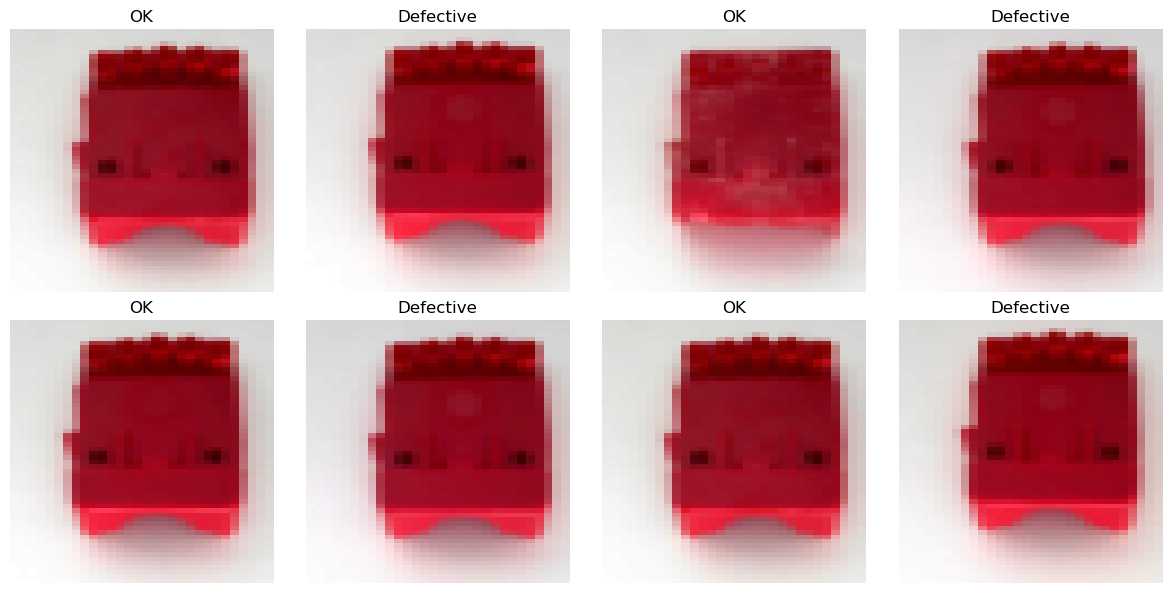

In [4]:
def show_balanced_samples(loader, classes=["OK", "Defective"]):
    ok_imgs = []
    def_imgs = []

    # Step 1: Collect 4 OK and 4 Defective samples
    for images, labels in loader:
        for img, label in zip(images, labels):
            if label == 0 and len(ok_imgs) < 4:
                ok_imgs.append(img)
            elif label == 1 and len(def_imgs) < 4:
                def_imgs.append(img)
            if len(ok_imgs) == 4 and len(def_imgs) == 4:
                break
        if len(ok_imgs) == 4 and len(def_imgs) == 4:
            break

    # Step 2: Alternate them
    ordered_imgs = []
    ordered_labels = []
    for i in range(4):
        ordered_imgs.extend([ok_imgs[i], def_imgs[i]])
        ordered_labels.extend([0, 1])

    # Step 3: Get true image shape
    _, H, W = ordered_imgs[0].shape
    aspect = W / H

    # Step 4: Plot
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for idx in range(8):
        img = ordered_imgs[idx].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize

        axes[idx].imshow(img)
        axes[idx].set_title(classes[ordered_labels[idx]])
        axes[idx].axis("off")
        axes[idx].set_aspect(aspect)  # This preserves correct shape!

    plt.tight_layout()
    plt.show()

show_balanced_samples(train_loader)

In [5]:
# Define CNN
class CNN(nn.Module):
    def __init__(self, num_filters: int = NUMBER_OF_FILTERS, dropout: float = DROPOUT_RATE):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 60, 30)
            out = self.features(dummy)
            flat_size = out.view(1, -1).shape[1]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [6]:
# Train function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
    return running_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

# Run training multiple times
all_losses = []
all_accuracies = []

for run in range(NUM_RUNS):
    print(f"Run {run+1}/{NUM_RUNS}")
    set_seed(SEED + run)  # Different seed for each run
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    losses, accuracies = [], []
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, criterion, optimizer, device)
        losses.append(loss)
        accuracies.append(acc)
        print(f"  Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    all_losses.append(losses)
    all_accuracies.append(accuracies)
    avg_loss = np.mean(losses)
    avg_acc = np.mean(accuracies)
    print(f"    Run {run+1} - Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_acc:.4f}")


# Convert to arrays
loss_array = np.array(all_losses)
acc_array = np.array(all_accuracies)

# Compute mean and std
loss_mean = loss_array.mean(axis=0)
loss_std = loss_array.std(axis=0)
acc_mean = acc_array.mean(axis=0)
acc_std = acc_array.std(axis=0)

Run 1/5
  Epoch 1/5 - Loss: 0.6944, Accuracy: 0.4926
  Epoch 2/5 - Loss: 0.6907, Accuracy: 0.4853
  Epoch 3/5 - Loss: 0.6879, Accuracy: 0.5441
  Epoch 4/5 - Loss: 0.6823, Accuracy: 0.5735
  Epoch 5/5 - Loss: 0.6751, Accuracy: 0.5956
    Run 1 - Average Loss: 0.6861, Average Accuracy: 0.5382
Run 2/5
  Epoch 1/5 - Loss: 0.7003, Accuracy: 0.4485
  Epoch 2/5 - Loss: 0.6884, Accuracy: 0.5221
  Epoch 3/5 - Loss: 0.6826, Accuracy: 0.5809
  Epoch 4/5 - Loss: 0.6661, Accuracy: 0.6618
  Epoch 5/5 - Loss: 0.6279, Accuracy: 0.6103
    Run 2 - Average Loss: 0.6730, Average Accuracy: 0.5647
Run 3/5
  Epoch 1/5 - Loss: 0.7002, Accuracy: 0.5221
  Epoch 2/5 - Loss: 0.7007, Accuracy: 0.4779
  Epoch 3/5 - Loss: 0.6838, Accuracy: 0.6103
  Epoch 4/5 - Loss: 0.6819, Accuracy: 0.5515
  Epoch 5/5 - Loss: 0.6787, Accuracy: 0.5956
    Run 3 - Average Loss: 0.6891, Average Accuracy: 0.5515
Run 4/5
  Epoch 1/5 - Loss: 0.6987, Accuracy: 0.4853
  Epoch 2/5 - Loss: 0.6925, Accuracy: 0.5221
  Epoch 3/5 - Loss: 0.7020

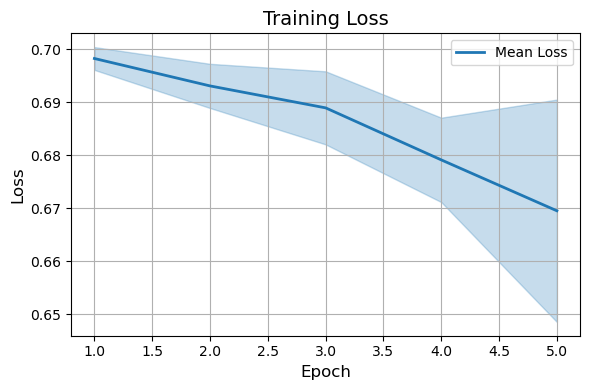

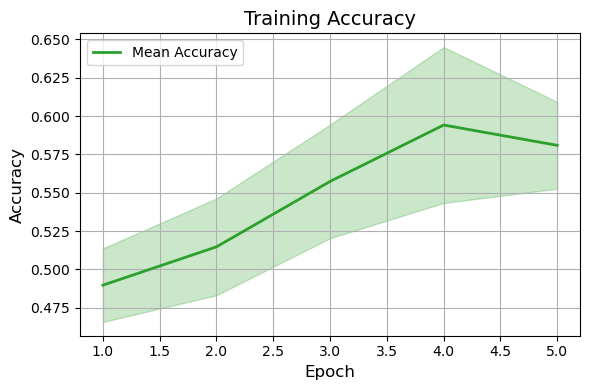

In [7]:
# Ensure output folder exists
os.makedirs("plots/baseline", exist_ok=True)

epochs = np.arange(1, EPOCHS + 1)

# ---------- LOSS PLOT ----------
plt.figure(figsize=(6, 4))
plt.plot(epochs, loss_mean, label='Mean Loss', color='tab:blue', linewidth=2)
plt.fill_between(epochs, loss_mean - loss_std, loss_mean + loss_std, alpha=0.25, color='tab:blue')
plt.title('Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("plots/baseline/training_loss.png", dpi=300)
plt.show()
plt.close()

# ---------- ACCURACY PLOT ----------
plt.figure(figsize=(6, 4))
plt.plot(epochs, acc_mean, label='Mean Accuracy', color='tab:green', linewidth=2)
plt.fill_between(epochs, acc_mean - acc_std, acc_mean + acc_std, alpha=0.25, color='tab:green')
plt.title('Training Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("plots/baseline/training_accuracy.png", dpi=300)
plt.show()
plt.close()
